# Current-weather data GFS global analysis

## Load in wind data, and compute global fields for a KE budget

#### First install miniconda (web-search it). 

#### Then, set up and enter an environment with these key packages:
`conda create -name ATM651 -c conda-forge xarray netcdf4 windspharm jupyterlab`
or use your "base" environment 
`conda install -c conda-forge xarray netcdf4 windspharm jupyterlab`

pro tip: mamba is faster than conda, a workalike

Or, you could run this code in Google Colab, using tactics [in this notebook](https://colab.research.google.com/drive/1cwVWzP4F_iynK9TjNJCy0GmB1VO-lbWm?usp=sharing)

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np 
from datetime import datetime, timedelta

# Unidata current weather grids 

In [12]:
# https://thredds.ucar.edu/thredds/catalog/catalog.html
# ds means "dataset"
# Best time series is analyses up to present, then forecasts into future
# One challenge is that different fields have different names for time dimension
# (because GRIB was designed as a message format not a file format)

ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/Best' )
ds

<xarray.Dataset>
Dimensions:                                                                     (
                                                                                 lat: 181,
                                                                                 lon: 360,
                                                                                 time: 373,
                                                                                 time1: 372,
                                                                                 time2: 372,
                                                                                 ...
                                                                                 depth_below_surface_layer_bounds_1: 2,
                                                                                 height_above_ground_layer_bounds_1: 2,
                                                                                 height_above_ground_layer1_bounds_1: 2,
                                                                                 pressure_difference_layer1_bounds_1: 2,
                                                                                 pressure_difference_layer2_bounds_1: 2,
                                                                                 sigma_layer_bounds_1: 2)
Coordinates: (12/31)
  * lat                                                                         (lat) float32 ...
  * lon                                                                         (lon) float32 ...
  * time                                                                        (time) datetime64[ns] ...
    reftime                                                                     (time) datetime64[ns] ...
  * time1                                                                       (time1) datetime64[ns] ...
    reftime1                                                                    (time1) datetime64[ns] ...
    ...                                                                          ...
  * isobaric1                                                                   (isobaric1) float32 ...
  * height_above_ground4                                                        (height_above_ground4) float32 ...
  * height_above_ground5                                                        (height_above_ground5) float32 ...
  * sigma                                                                       (sigma) float32 ...
  * hybrid                                                                      (hybrid) float32 ...
  * hybrid1                                                                     (hybrid1) float32 ...
Dimensions without coordinates: time2_bounds_1, time3_bounds_1,
                                pressure_difference_layer_bounds_1,
                                depth_below_surface_layer_bounds_1,
                                height_above_ground_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                pressure_difference_layer2_bounds_1,
                                sigma_layer_bounds_1
Data variables: (12/180)
    LatLon_Projection                                                           int32 ...
    time2_bounds                                                                (time2, time2_bounds_1) datetime64[ns] ...
    time3_bounds                                                                (time3, time3_bounds_1) datetime64[ns] ...
    pressure_difference_layer_bounds                                            (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 ...
    depth_below_surface_layer_bounds                                            (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 ...
    height_above_ground_layer_bounds                                            (

## To facilitate global integrals, create dMass and dArea and dLon fields
#### add them to the dataset ds

In [36]:
# Add new 'dMass' and 'dLon' and 'dArea' data arrays to the dataset for 
# making vertical mean, zonal mean, area mean 

ds['dMass'] = ( ds.isobaric.diff(dim='isobaric') / 9.81 ).assign_attrs(units='kg/m^2')  
ds['dLon'] = ( ds.lon.diff(dim='lon') ).assign_attrs(units='degrees')       

# dp/g is kg/m2 units

# m2, from square degrees, based on 10000 km eq-pole distance (111111 m/deg)
# CAREFUL! dlat is negative
ds['dArea'] =-(ds.lat.diff(dim='lat') * 111111.1 *\
               ds.lon.diff(dim='lon') * 111111.1 *np.cos(ds.lat *np.pi/180.) \
               ).assign_attrs(units='m^2')

# ds.dArea.plot()

In [37]:
# Function to plot coastlines 

def coastlines(**kwargs): 
    ds.Geopotential_height_surface[0].plot.contour(levels=[0.1], **kwargs)

## Extract 3D winds, and surface friction (momentum flux) 

In [38]:
winds = ds[ ['u-component_of_wind_isobaric','v-component_of_wind_isobaric', \
             'Vertical_velocity_pressure_isobaric','Geopotential_height_isobaric',\
             'Absolute_vorticity_isobaric'] ]

# winds 

In [39]:
friction = ds[ \
    ['Momentum_flux_u-component_surface_Mixed_intervals_Average',\
     'Momentum_flux_v-component_surface_Mixed_intervals_Average'] ]

friction    # time2 seems to be the name for time in these variables, N/m2 the units

<xarray.Dataset>
Dimensions:                                                    (time2: 372,
                                                                lat: 181,
                                                                lon: 360)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time2                                                      (time2) datetime64[ns] ...
    reftime2                                                   (time2) datetime64[ns] ...
Data variables:
    Momentum_flux_u-component_surface_Mixed_intervals_Average  (time2, lat, lon) float32 ...
    Momentum_flux_v-component_surface_Mixed_intervals_Average  (time2, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

## Before calculating things, let's select a single time (or time subset) 

In [40]:
# Select the present time (plus or minus 1.5 hours will always get a time in 3h data) 
# Squeeze() out time dimension since it has only one value

one_hour = timedelta(hours=1) 

timeslice = slice(datetime.now()-1.5*one_hour,datetime.now()+1.5*one_hour)
winds_now    = winds.sel(    time= timeslice ).squeeze()
friction_now = friction.sel( time2=timeslice ).squeeze()

winds_now

<xarray.Dataset>
Dimensions:                              (isobaric: 41, lat: 181, lon: 360)
Coordinates:
  * lat                                  (lat) float32 90.0 89.0 ... -89.0 -90.0
  * lon                                  (lon) float32 0.0 1.0 ... 358.0 359.0
    time                                 datetime64[ns] 2023-12-02T12:00:00
  * isobaric                             (isobaric) float32 1.0 2.0 ... 1e+05
    reftime                              datetime64[ns] ...
Data variables:
    u-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    v-component_of_wind_isobaric         (isobaric, lat, lon) float32 ...
    Vertical_velocity_pressure_isobaric  (isobaric, lat, lon) float32 ...
    Geopotential_height_isobaric         (isobaric, lat, lon) float32 ...
    Absolute_vorticity_isobaric          (isobaric, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

# Global KE and its budget terms

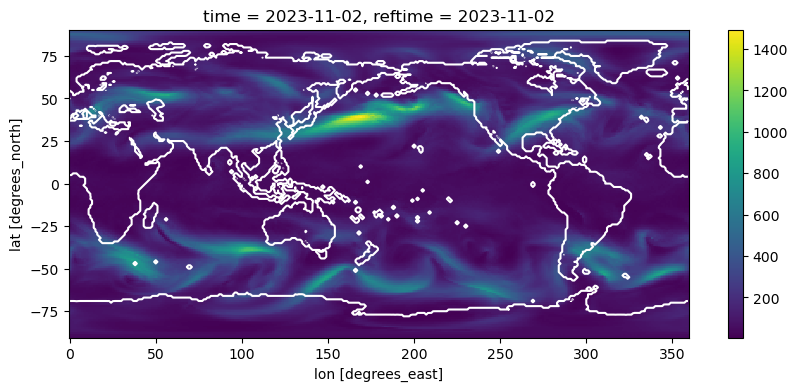

In [42]:
KE_now =0.5*( winds_now['u-component_of_wind_isobaric']**2 +\
              winds_now['v-component_of_wind_isobaric']**2 )
# J/kg, simple mean is 291.79769897

# Vertical Mean: KE-weighted average of dMass, is one way to look at it
Vmean_KE = (KE_now*ds.dMass).sum(dim='isobaric') / (ds.dMass).sum(dim='isobaric')
Vmean_KE.plot(size=4, aspect=2.5)
coastlines(colors='white')

In [9]:
# Area average: Vmean_KE weighted average of dA, is one way to look at it

(Vmean_KE*ds.dArea).sum(dim=['lat','lon']) / (ds.dArea).sum(dim=['lat','lon'])

<xarray.DataArray ()>
array(163.23537, dtype=float32)
Coordinates:
    time     datetime64[ns] 2023-11-12T15:00:00
    reftime  datetime64[ns] 2023-11-12T12:00:00

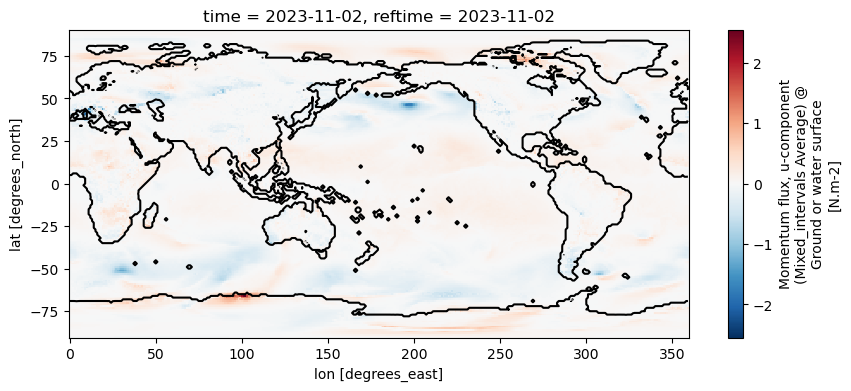

In [44]:
# Friction 
friction_now['Momentum_flux_u-component_surface_Mixed_intervals_Average'].plot(size=4, aspect=2.5)
coastlines(colors='black')

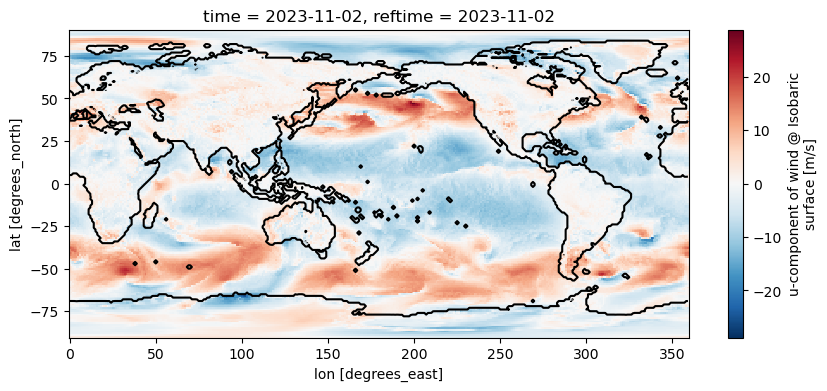

In [45]:
# Friction (N/m2) dotted into surface winds is the KE sink term 
u1000 = winds_now['u-component_of_wind_isobaric'].sel(isobaric=100000) # CAREFUL! units are Pa
u1000.plot(size=4, aspect=2.5)
coastlines(colors='black')

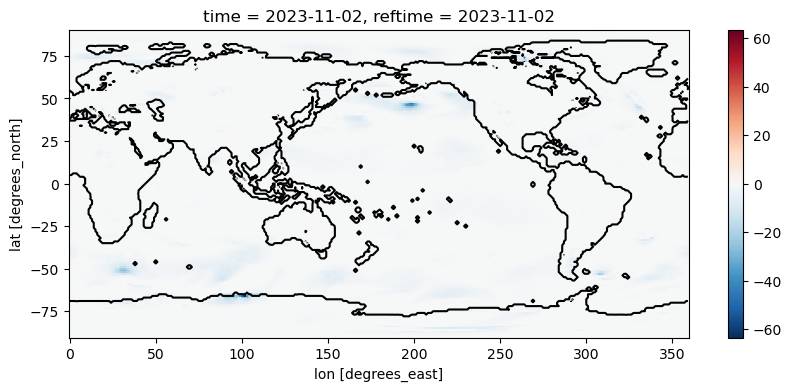

In [47]:
# Friction (N/m2) dotted into 1000mb winds is the KE sink term: all negative? 
(u1000*friction_now['Momentum_flux_u-component_surface_Mixed_intervals_Average']).plot(size=4, aspect=2.5)
coastlines(colors='black')

Text(0.5, 1.0, 'FdotV units: N/m2 * m/s')

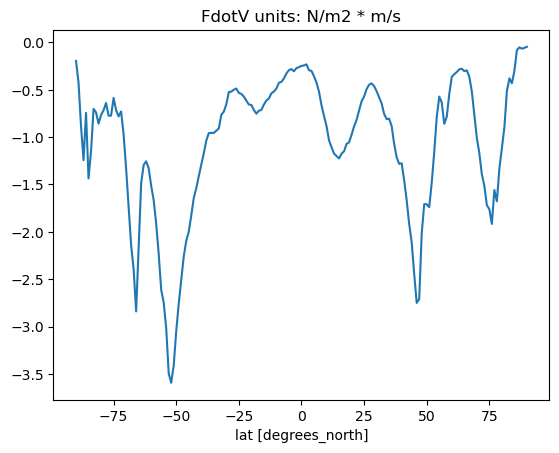

In [49]:
FdotV = (winds_now['u-component_of_wind_isobaric'].sel(isobaric=100000) *\
         friction_now['Momentum_flux_u-component_surface_Mixed_intervals_Average'] + \
         winds_now['v-component_of_wind_isobaric'].sel(isobaric=100000) *\
         friction_now['Momentum_flux_v-component_surface_Mixed_intervals_Average'] ) 

# Zonal (longitudinal) mean of FdotV at each latitude 
( (FdotV*ds.dLon).sum(dim='lon') / ds.dLon.sum(dim='lon') ).plot()
plt.title( 'FdotV units: N/m2 * m/s' )

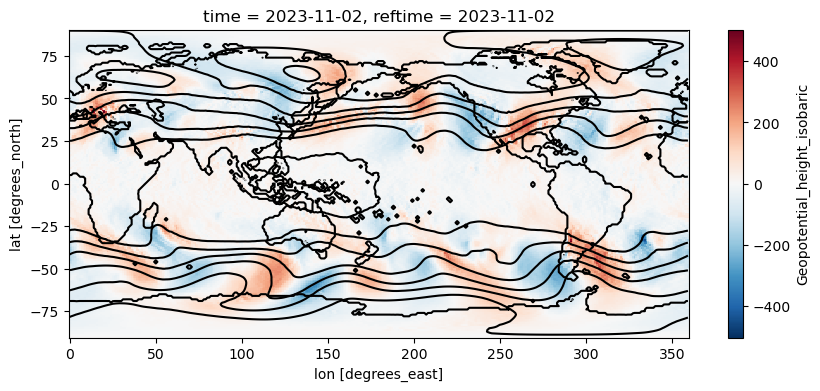

In [56]:
dPhidy = winds_now.Geopotential_height_isobaric.differentiate('lat') \
            *9.8/111111.1 # meters per degree of latitude makes this dPhi/dy
dPhidlon = winds_now.Geopotential_height_isobaric.differentiate('lon') \
            *9.8 

# dPhidx = dPhidlon /111111.1 / np.cos(winds_now.lat) # meters per degree of longitude makes this dPhi/dx
# WHY DOESNT THE ABOVE LINE WORK RIGHT? cos(lat) is not broadcast properly to 3

dPhidlon.sel(isobaric=20000).plot(size=4, aspect=2.5)
winds_now.sel(isobaric=20000).Geopotential_height_isobaric.plot.contour(levels=10,colors='black')
coastlines(colors='black')

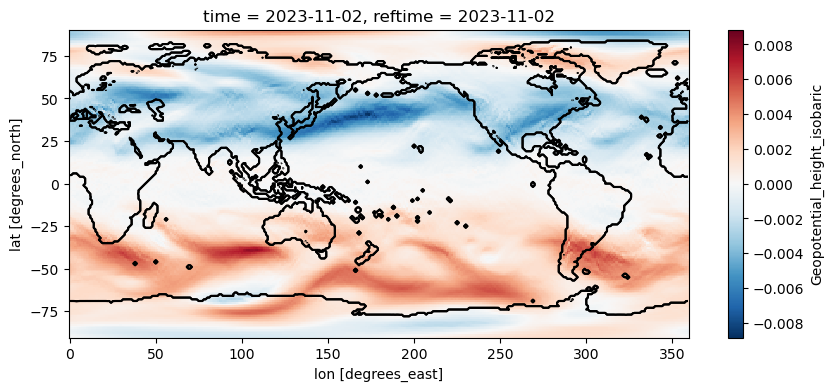

In [59]:
dPhidy.sel(isobaric=20000).plot(size=4, aspect=2.5)
ds.Geopotential_height_surface[0].plot.contour(colors='black', levels=[0.1] )
coastlines(colors='black')

--------------
# Assignment ideas:

### 1. estimate the residence time of KE (about a week, from HW3): get the units straight
### 2. Make a time series instead of a single time: how much does KE go up and down? 
### 3. Estimate the KE source term -V.grad(Phi) = -V.grad(gZ)

...

In [2]:
!date

Sat Dec  2 12:29:02 EST 2023
